# Gurobi

In [6]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
import os
from datetime import datetime

In [7]:
def generate_random_graph(n_nodes=8, p=0.5, seed=None):
    G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = np.random.randint(1, 10)
    return G

In [8]:
def maxcut_gurobi(G):
    n = G.number_of_nodes()
    m = gp.Model("maxcut")
    m.setParam('OutputFlag', 0)  # Silence output

    # Binary variables for each node
    x = m.addVars(n, vtype=GRB.BINARY, name="x")

    # Objective: sum weights where endpoints are in different sets
    obj = gp.quicksum(
        G.edges[i, j]['weight'] * (x[i] + x[j] - 2 * x[i] * x[j])
        for i, j in G.edges()
    )
    m.setObjective(obj, GRB.MAXIMIZE)
    m.optimize()

    cut = [int(x[i].X) for i in range(n)]
    cut_value = m.objVal
    return cut, cut_value

In [9]:
def run_gurobi_experiment_time_budget(sizes, edge_prob=0.5, time_per_size=420):
    all_cut_values = []
    all_times = []
    for n_nodes in sizes:
        cut_values = []
        times = []
        start_time = time.time()
        g_idx = 0
        while time.time() - start_time < time_per_size:
            G = generate_random_graph(n_nodes=n_nodes, p=edge_prob, seed=g_idx)
            t0 = time.time()
            cut, value = maxcut_gurobi(G)
            t1 = time.time()
            cut_values.append(value)
            times.append(t1 - t0)
            g_idx += 1
        all_cut_values.append(cut_values)
        all_times.append(times)
        print(f"Size: {n_nodes} | Graphs: {g_idx} | Mean Cut: {np.mean(cut_values):.2f} | Mean Time: {np.mean(times):.3f}s")
    return all_cut_values, all_times

Size: 8 | Graphs: 461065 | Mean Cut: 57.62 | Mean Time: 0.001s
Size: 10 | Graphs: 188280 | Mean Cut: 89.12 | Mean Time: 0.003s
Size: 12 | Graphs: 98450 | Mean Cut: 126.80 | Mean Time: 0.006s
Size: 14 | Graphs: 72226 | Mean Cut: 170.54 | Mean Time: 0.008s
Size: 16 | Graphs: 54350 | Mean Cut: 220.31 | Mean Time: 0.011s
Size: 18 | Graphs: 36887 | Mean Cut: 276.05 | Mean Time: 0.016s
Results saved to data/gur-data/gur_20250615_151121.csv


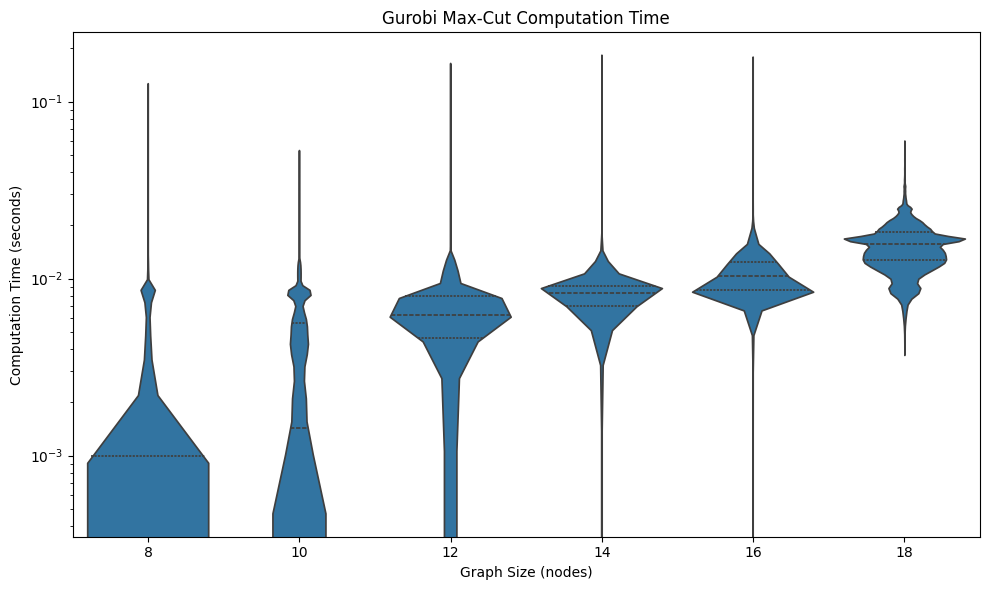

Plot saved to gur_violin_20250615_151123.png


In [10]:
sizes = [8, 10, 12, 14, 16, 18]
edge_prob = 0.5
time_per_size = 600  # seconds
# 6 sizes per 600 seconds = 1 hour total

cut_values, times = run_gurobi_experiment_time_budget(sizes, edge_prob, time_per_size)

df = pd.DataFrame({
    'Graph Size': sum([[size]*len(vals) for size, vals in zip(sizes, cut_values)], []),
    'Cut Value': sum(cut_values, []),
    'Time': sum(times, [])
})

# Save CSV
os.makedirs("data/gur-data", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"data/gur-data/gur_{timestamp}.csv"
df.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")

# Save plot
os.makedirs("plots/gur-plots", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_path = f"gur_violin_{timestamp}.png"

plt.figure(figsize=(10,6))
sns.violinplot(x='Graph Size', y='Time', data=df, inner='quartile', density_norm='width')
plt.title('Gurobi Max-Cut Computation Time')
plt.xlabel('Graph Size (nodes)')
plt.ylabel('Computation Time (seconds)')
plt.yscale('log')
plt.tight_layout()
plt.savefig(plot_path)
plt.show()
print(f"Plot saved to {plot_path}")